# OBJECTIVE OF THIS NOTEBOOK

In this notebook we want to have a look on the clicks table in the last two months. 

## Understanding Why referer_host Is Missing
Clicks without a referer_host usually happen due to:
- Direct Traffic (e.g., users typing the URL or clicking from emails/apps).
- Privacy Restrictions (e.g., HTTPS to HTTP transitions).
- Blocked by Browser Settings (some browsers strip referral data).
- Mobile Apps & Messengers (e.g., Instagram, WhatsApp don’t always pass referrer info).

### 1. **Click Performance Analysis**

- Click trends over time (`created_at`): Identify peak hours, days, or seasonal trends.
- Clicks per `product_link_id`: Find the most clicked product links.
- Clicks per `source_id`: Identify the most effective brands.
### 2. **Traffic Source Analysis**

- Clicks by `referer_host`: Understand which platforms drive the most traffic (e.g., Instagram, Twitter).
- Clicks by `ip_country`: Identify top-performing regions for each brand.
- Clicks by `foreign_country`: Measure international traffic.
### 3. **Fraud Detection**

- Clicks per `ip`: Detect potential bot activity or unusual click patterns.
- Clicks per `user_agent`: Spot excessive clicks from the same device/browser.
- Clicks per second/minute per `product_link_id`: Identify spikes that may indicate fraudulent activity.
### 4. **Geographic Insights**

- Click distribution heatmap by `ip_country`.
- Conversion rates by `ip_country` (if sales data is available)

### 5. **Referral Analysis**

- Click conversion by `referer`: Identify high-quality traffic sources.
- Click distribution per `referer_host`: Find out which social media or websites perform best.

In [169]:
import warnings
warnings.simplefilter('ignore')

import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [170]:
#importing the data into a pandas data frame
raw_clicks_df = pd.read_csv("data/clicks.csv", sep=',')

#create working copy of the raw data
clicks_df = raw_clicks_df.copy()

In [171]:
clicks_df.columns

Index(['_AIRBYTE_RAW_ID', '_AIRBYTE_EXTRACTED_AT', '_AIRBYTE_META', 'ID', 'IP', 'CPC', 'TARGET', 'REFERER', 'ACTOR_ID', 'CURRENCY', 'PROCESSED', 'SOURCE_ID', 'ACTOR_TYPE', 'CREATED_AT', 'IP_COUNTRY', 'UPDATED_AT', 'USER_AGENT', '_AB_CDC_LSN', 'REFERER_HOST', 'CLASSIFICATION', 'FOREIGN_COUNTRY', 'PRODUCT_LINK_ID', '_AB_CDC_DELETED_AT', '_AB_CDC_UPDATED_AT'], dtype='object')

id - id number; actor_id - actor ID (light user id); product_link_id; created_at - time when the clicks were created (date and time); updated_at - time when the clicks were updated (date and time); user_agent - device of the click; ip - ip address; ip_country-country abbreviation;referer - link referer; actor_type	- [NULL], LightUser (Instagram); source_id-network, shop, country; currency - currency of the cpc; target - target_host	stylink, linkmaker, webestats...

In [172]:
# choose only the columns we want to consider
clicks_df = clicks_df[['ID', 'PRODUCT_LINK_ID', 'SOURCE_ID', 'ACTOR_ID', 'ACTOR_TYPE', 'IP','IP_COUNTRY','FOREIGN_COUNTRY','USER_AGENT','REFERER', 'REFERER_HOST', 'PROCESSED', 'CREATED_AT']]

In [173]:
clicks_df.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT
0,623979187,5418289,rakuten-hm-pl,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02.000
1,623979186,5417799,amazon-uk,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02.000
2,623979185,5416047,amazon-de,290448983.0,LightUser,185.131.74.168,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/32YYmiJV...,stylink,False,2025-03-26 12:23:02.000
3,623979184,5418504,amazon-uk,290447611.0,LightUser,188.30.133.168,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/L4lQhl7B...,stylink,False,2025-03-26 12:23:02.000
4,623979183,5418042,rakuten-hm-de,290449008.0,LightUser,178.115.44.179,at,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,https://app.stylink.com/ref_ios/redir/DQq9AS9l...,stylink,False,2025-03-26 12:23:02.000


In [174]:
#Let's have a look at the shep of our dataset, meaning how long and wide it is
clicks_df.shape

(9152400, 13)

We have 9.152.400 rows and 14 columns in our dataset.

In [175]:
# we now want to check our data-types
clicks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9152400 entries, 0 to 9152399
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ID               int64  
 1   PRODUCT_LINK_ID  int64  
 2   SOURCE_ID        object 
 3   ACTOR_ID         float64
 4   ACTOR_TYPE       object 
 5   IP               object 
 6   IP_COUNTRY       object 
 7   FOREIGN_COUNTRY  object 
 8   USER_AGENT       object 
 9   REFERER          object 
 10  REFERER_HOST     object 
 11  PROCESSED        bool   
 12  CREATED_AT       object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 846.7+ MB


In [176]:
#check for duplicate rows in product_link_id column
clicks_df['PRODUCT_LINK_ID'].duplicated().value_counts()

True     8930179
False     222221
Name: PRODUCT_LINK_ID, dtype: int64

So we have data on 222.221 product links to analyse. In our database, the same link can appear multiple times (also clicks can appear more than on one day).

In [177]:
#check how many duplicated rows exist in the data frame
no_of_dups = clicks_df.duplicated().sum()
print("number of rows having complete row duplicate :", no_of_dups)

number of rows having complete row duplicate : 0


In [178]:
#check for null values
clicks_df.isna().sum()

ID                       0
PRODUCT_LINK_ID          0
SOURCE_ID                5
ACTOR_ID           1099602
ACTOR_TYPE         1099602
IP                       0
IP_COUNTRY             595
FOREIGN_COUNTRY        595
USER_AGENT             546
REFERER            2896551
REFERER_HOST       2896553
PROCESSED                0
CREATED_AT               0
dtype: int64

In [179]:
# NaN values in Referer and Referer_Host
print(clicks_df[['REFERER', 'REFERER_HOST']].isna().sum())

REFERER         2896551
REFERER_HOST    2896553
dtype: int64


In [180]:
#check number of unique values in the dataset
for i in list(clicks_df[['SOURCE_ID', 'IP', 'USER_AGENT', 'REFERER', 'REFERER_HOST']]):
    print(f'Unique {i}: {clicks_df[i].nunique()}')

Unique SOURCE_ID: 2089
Unique IP: 3310129
Unique USER_AGENT: 85591
Unique REFERER: 5611509
Unique REFERER_HOST: 459


In [181]:
clicks_df['CREATED_AT'] = pd.to_datetime(clicks_df['CREATED_AT'])

In [182]:
#check time range of the dataset
print(f"Min Date Link: {clicks_df['CREATED_AT'].min()}")
print(f"Max Date Link: {clicks_df['CREATED_AT'].max()}")

Min Date Link: 2025-03-02 00:00:00
Max Date Link: 2025-03-26 12:23:02


In [183]:
data_df = clicks_df.assign(
    click_date = lambda x: x['CREATED_AT'].dt.date,
    click_day = lambda x: x['CREATED_AT'].dt.day,
    click_day_of_week = lambda x: x['CREATED_AT'].dt.dayofweek,
    click_hour = lambda x: x['CREATED_AT'].dt.hour
)

Note: It is assumed the week starts on Monady, which is denoted by 0 and ends on Sunday which is denoted by 6.

In [184]:
data_df.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour
0,623979187,5418289,rakuten-hm-pl,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02,2025-03-26,26,2,12
1,623979186,5417799,amazon-uk,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12
2,623979185,5416047,amazon-de,290448983.0,LightUser,185.131.74.168,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/32YYmiJV...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12
3,623979184,5418504,amazon-uk,290447611.0,LightUser,188.30.133.168,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/L4lQhl7B...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12
4,623979183,5418042,rakuten-hm-de,290449008.0,LightUser,178.115.44.179,at,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,https://app.stylink.com/ref_ios/redir/DQq9AS9l...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12


In [185]:
#weekday
clicks_date_df = data_df.groupby("click_date")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
clicks_date_df.columns = ["click_date", "total_clicks"]
clicks_date_df.head(20)

,click_date,total_clicks
0,2025-03-09,458096
1,2025-03-07,429880
2,2025-03-15,429129
3,2025-03-25,419289
4,2025-03-06,418385
5,2025-03-16,401320
6,2025-03-08,390386
7,2025-03-02,386912
8,2025-03-10,381804
9,2025-03-23,375615


[Text(0.5, 1.0, 'Clicks by Date'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Total Clicks')]

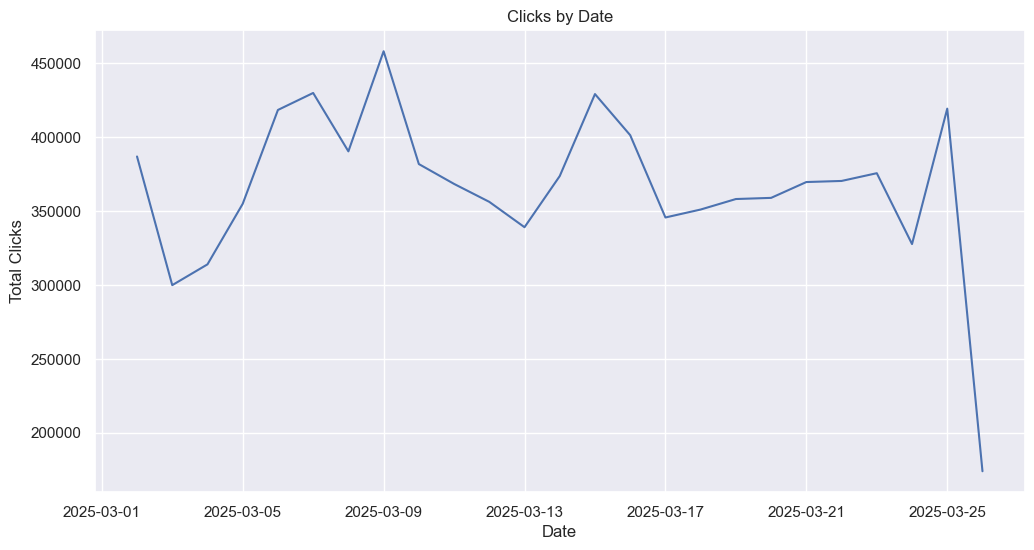

In [186]:
fig, ax = plt.subplots()
sns.lineplot(x='click_date', y='total_clicks', data=clicks_date_df.reset_index(), ax=ax)
ax.set(title="Clicks by Date", xlabel='Date', ylabel='Total Clicks')

In [187]:
data_df['weekend'] = data_df.click_date.isin([5,6])
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
data_df['weekday'] = data_df.click_day_of_week.map(dayOfWeek)

In [188]:
#weekday
weekday_clicks_df = data_df.groupby("weekday")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
weekday_clicks_df.columns = ["weekday", "total_clicks"]
weekday_clicks_df.head(20)

,weekday,total_clicks
0,Sunday,1621943
1,Tuesday,1452652
2,Monday,1355038
3,Wednesday,1243292
4,Saturday,1189886
5,Friday,1173199
6,Thursday,1116390


[Text(0.5, 1.0, 'Clicks by Weekday'),
 Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Total Clicks')]

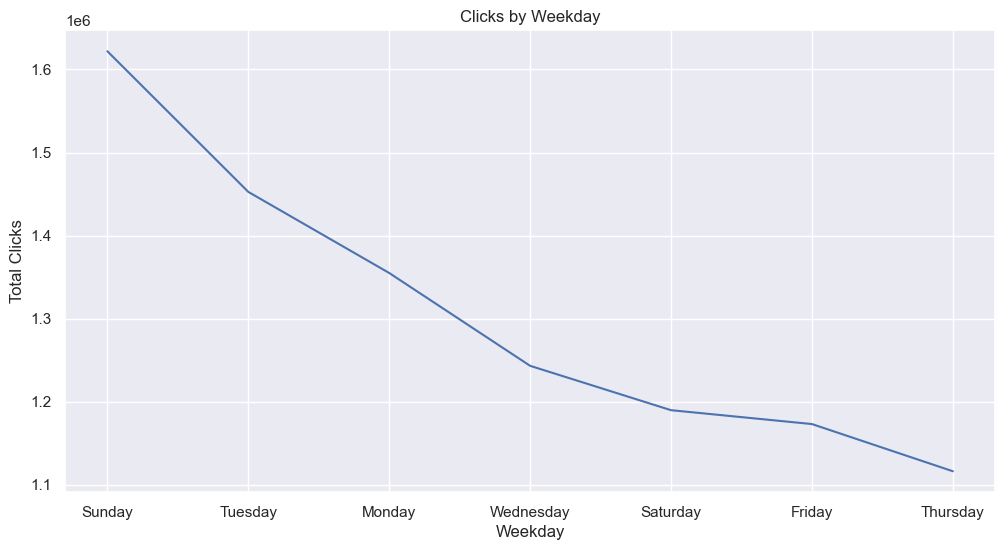

In [189]:
fig, ax = plt.subplots()
sns.lineplot(x='weekday', y='total_clicks', data=weekday_clicks_df.reset_index(), ax=ax)
ax.set(title="Clicks by Weekday", xlabel='Weekday', ylabel='Total Clicks')

In [190]:
clicks_hour_df = data_df.groupby("click_hour")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
clicks_hour_df.columns = ["hour", "total_clicks"]
clicks_hour_df.head(20)

,hour,total_clicks
0,20,772758
1,19,727805
2,21,656142
3,18,591363
4,11,456507
5,12,452585
6,17,444770
7,8,440380
8,16,437993
9,9,432254


[Text(0.5, 1.0, 'Clicks by Hour'),
 Text(0.5, 0, 'Hour'),
 Text(0, 0.5, 'Total Clicks')]

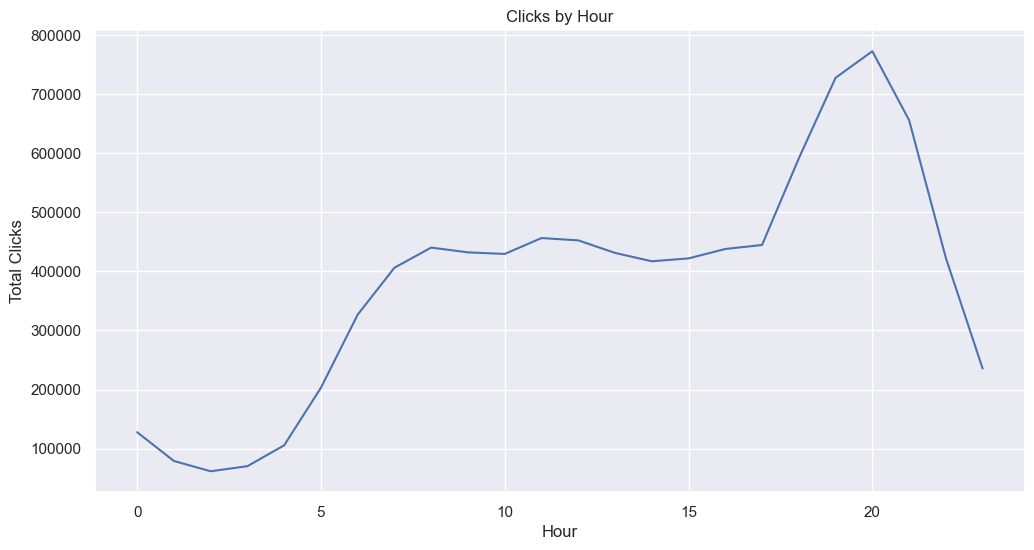

In [191]:
fig, ax = plt.subplots()
sns.lineplot(x='hour', y='total_clicks', data=clicks_hour_df.reset_index(), ax=ax)
ax.set(title="Clicks by Hour", xlabel='Hour', ylabel='Total Clicks')

In [192]:
source_clicks_df = data_df.groupby("SOURCE_ID")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
source_clicks_df.columns = ["SOURCE_ID", "total_clicks"]
source_clicks_df.head(10)

,SOURCE_ID,total_clicks
0,rakuten-hm-de,1788377
1,amazon-de,1375788
2,rakuten-hmvip-de,462831
3,rakuten-hm-uk,367273
4,rakuten-nl-hm-nl,331245
5,private-otto,294912
6,amazon-uk,251071
7,impact-asos-de,234384
8,rakuten-hmvip-pl,228505
9,rakuten-hm-pl,185897


In [193]:
source_clicks_links_df = data_df.groupby("SOURCE_ID")['PRODUCT_LINK_ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
source_clicks_links_df.columns = ["SOURCE_ID", "total_link_clicks"]
source_clicks_links_df.head(10)

,SOURCE_ID,total_link_clicks
0,rakuten-hm-de,41814
1,amazon-de,24333
2,rakuten-hm-uk,11202
3,private-otto,7346
4,impact-asos-de,7021
5,impact-uk-asos-uk,6156
6,amazon-uk,5330
7,rakuten-hmvip-de,4324
8,rakuten-nl-hm-nl,4275
9,rakuten-hm-pl,4150


#### Total clicked product link ids

In [194]:
pr_lnk_df = data_df.groupby("PRODUCT_LINK_ID")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
pr_lnk_df.columns = ["PRODUCT_LINK_ID", "total_clicks"]
pr_lnk_df.head(10)

,PRODUCT_LINK_ID,total_clicks
0,5401034,38202
1,5412145,22650
2,5374017,19867
3,5332462,19548
4,5378253,19083
5,5348939,17664
6,5341128,14723
7,5344814,14331
8,5348399,13633
9,5379111,13549


#### Clicks by Refer Host

In [195]:
print(data_df.REFERER_HOST.nunique())

459


In [196]:
ref_host_df = data_df.groupby("REFERER_HOST")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ref_host_df.columns = ["REFERER_HOST", "total_clicks"]
ref_host_df.head(10)

,REFERER_HOST,total_clicks
0,stylink,5794888
1,instagram,155372
2,youtube,95520
3,facebook,78139
4,stylist,36659
5,pinterest,18572
6,linktr,11243
7,mittlivpalandet,11227
8,minimalissmo,6649
9,diski,5637


### Clicks Over Time for Topn N `referer_host`

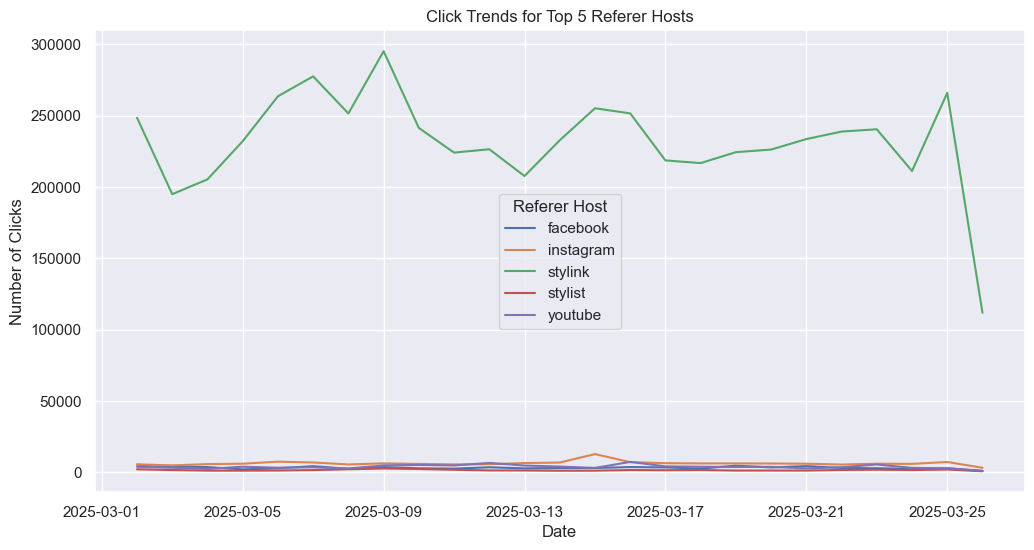

In [197]:
def plot_top_referers(df, top_n=5):
    # Count total clicks per referer_host
    top_referers = df['REFERER_HOST'].value_counts().head(top_n).index
    
    # Filter dataset for only the top referers
    filtered_df = df[df['REFERER_HOST'].isin(top_referers)]
    
    # Group by date and referer_host
    clicks_per_day = filtered_df.groupby(['click_date', 'REFERER_HOST']).size().unstack().fillna(0)
    
    # Plot
    clicks_per_day.plot(kind='line', figsize=(12, 6))
    plt.xlabel("Date")
    plt.ylabel("Number of Clicks")
    plt.title(f"Click Trends for Top {top_n} Referer Hosts")
    plt.legend(title="Referer Host")
    plt.show()

# Example usage
plot_top_referers(data_df)

### Clicks by Stylink vs. Social Media vs. Search Engines

In [198]:
def categorize_referers(df):
    stylist_media = ['stylist']
    stylink_media = ['stylink']
    social_media = ['facebook', 'instagram', 'twitter', 'linkedin', 'pinterest', 'tiktok', 'snapchat', 'reddit']
    search_engines = ['google', 'bing', 'yahoo', 'duckduckgo']

    df['referer_category'] = 'Other'
    df.loc[df['REFERER_HOST'].isin(stylist_media), 'referer_category'] = 'Stylist'
    df.loc[df['REFERER_HOST'].isin(stylink_media), 'referer_category'] = 'Stylink'
    df.loc[df['REFERER_HOST'].isin(social_media), 'referer_category'] = 'Social Media'
    df.loc[df['REFERER_HOST'].isin(search_engines), 'referer_category'] = 'Search Engine'

    return df

# Example usage
df = categorize_referers(data_df)
print(df['referer_category'].value_counts())

Stylink          5794888
Other            3062088
Social Media      254783
Stylist            36659
Search Engine       3982
Name: referer_category, dtype: int64


#### Clicks by IP

In [199]:
ip_df = data_df.groupby("IP")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ip_df.columns = ["IP", "total_clicks"]
ip_df.head(10)

,IP,total_clicks
0,49.13.129.56,26671
1,46.4.97.80,13586
2,104.28.62.24,13299
3,104.28.62.25,8456
4,104.28.30.74,5525
5,104.28.62.43,5433
6,104.28.30.75,5015
7,104.28.62.32,4463
8,104.28.62.57,4345
9,104.28.62.41,4243


#### Clicks by IP country

In [200]:
data_df.columns

Index(['ID', 'PRODUCT_LINK_ID', 'SOURCE_ID', 'ACTOR_ID', 'ACTOR_TYPE', 'IP', 'IP_COUNTRY', 'FOREIGN_COUNTRY', 'USER_AGENT', 'REFERER', 'REFERER_HOST', 'PROCESSED', 'CREATED_AT', 'click_date', 'click_day', 'click_day_of_week', 'click_hour', 'weekend', 'weekday', 'referer_category'], dtype='object')

In [201]:
ip_country_df = data_df.groupby("IP_COUNTRY")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ip_country_df.columns = ["IP_COUNTRY", "total_clicks"]
ip_country_df.head(20)

,IP_COUNTRY,total_clicks
0,de,4670433
1,gb,1334643
2,pl,890265
3,nl,538459
4,at,343532
5,fr,205463
6,us,187023
7,ch,183573
8,ie,174037
9,be,81329


#### Clicks by foreign country

In [202]:
foreign_country_df = data_df.groupby("FOREIGN_COUNTRY")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
foreign_country_df.columns = ["FOREIGN_COUNTRY", "total_clicks"]
foreign_country_df.head(20)

,FOREIGN_COUNTRY,total_clicks
0,False,8122266
1,True,1029539


#### User Agent

In [203]:
user_agent_df = data_df.groupby("USER_AGENT")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
user_agent_df.columns = ["USER_AGENT", "total_clicks"]
user_agent_df.head(20)

,USER_AGENT,total_clicks
0,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,2415531
1,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,1307662
2,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,1116408
3,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,620069
4,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,543816
5,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1_1 like...,343328
6,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,337316
7,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,183911
8,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,163763
9,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,123968


## Why `referer_host` is empty?
Direct Traffic (e.g., users typing the URL or clicking from emails/apps).
Privacy Restrictions (e.g., HTTPS to HTTP transitions).
Blocked by Browser Settings (some browsers strip referral data).
Mobile Apps & Messengers (e.g., Instagram, WhatsApp don’t always pass referrer info).

- If certain `user_agent` values dominate the missing data, it’s likely due to specific browsers or apps.
- If all missing referrers have source_id from one brand, it might be due to their marketing setup.

In [204]:
# Check what % of clicks have missing referer_host
missing_referers = data_df['REFERER_HOST'].isna().sum()
total_clicks = len(data_df)
missing_percentage = (missing_referers / total_clicks) * 100

print(f"Missing referer_host: {missing_referers} ({missing_percentage:.2f}%)")

# Check distribution of missing referers by user_agent
missing_ua_distribution = df[df['REFERER_HOST'].isna()]['USER_AGENT'].value_counts()
print(missing_ua_distribution.head(10))

Missing referer_host: 2896553 (31.65%)
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/27.0 Chrome/125.0.0.0 Mobile Safari/537.36            1081522
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Mobile Safari/537.36                                 578218
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Mobile Safari/537.36                                 504910
Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Mobile/15E148 Safari/604.1       100942
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36 Edg/87.0.664.60               71082
Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3.1 Mobile/15E148 Safari/604.1      55222
Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) 

#### Inferring `referer_host` Using User-Agent Patterns
If some `user_agent` values always correspond to specific referrers, we can fill in missing values.

In [205]:
data_df['REFERER_MISSING'] = data_df['REFERER'].isna()
ua_pattern = data_df.groupby(['USER_AGENT'])['REFERER_MISSING'].sum().sort_values(ascending=False)
print(ua_pattern.head(20))

USER_AGENT
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/27.0 Chrome/125.0.0.0 Mobile Safari/537.36                                                                                                1081522
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Mobile Safari/537.36                                                                                                                     578218
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Mobile Safari/537.36                                                                                                                     504910
Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Mobile/15E148 Safari/604.1                                                                                           100942
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWe

In [206]:
print(ua_pattern.tail(20))

USER_AGENT
Mozilla/5.0 (Linux; Android 12; SM-G980F Build/SP1A.210812.016; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/133.0.6943.137 Mobile Safari/537.36 musical_ly_2023900030 JsSdk/1.0 NetType/WIFI Channel/googleplay AppName/musical_ly app_version/39.0.3 ByteLocale/de-DE ByteFullLocale/de-DE Region/DE AppId/1233 Spark/1.7.2 AppVersion/39.0.3 PIA/2.5.3 BytedanceWebview/d8a21c6      0
Mozilla/5.0 (Linux; Android 12; SM-G985F Build/SP1A.210812.016; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/133.0.6943.117 Mobile Safari/537.36 [FB_IAB/FB4A;FBAV/502.0.0.66.79;IABMV/1;]                                                                                                                                                                                              0
Mozilla/5.0 (Linux; Android 12; SM-G981B Build/SP1A.210812.016; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/134.0.6998.39 Mobile Safari/537.36 musical_ly_2023900030 JsSdk/1.0 NetTyp

In [207]:
ua_pattern.nunique()

311

Man kann dann sehen, dass bestimmte Geräte etc. besonders oft der Referer fehlt.

##### Nach SOURCE_ID, ACTOR_TYPE, FOREIGN_COUNTRY, IP_COUNTRY

In [208]:
cols = ['SOURCE_ID', 'ACTOR_TYPE', 'FOREIGN_COUNTRY', 'IP_COUNTRY']
for col in cols:
    print(data_df.groupby(col)['REFERER_MISSING'].sum().sort_values(ascending=False).head())

SOURCE_ID
amazon-de           495472
rakuten-hm-de       489690
rakuten-hmvip-pl    101500
private-otto         98520
rakuten-hmvip-de     98335
Name: REFERER_MISSING, dtype: int64
ACTOR_TYPE
LightUser    2360208
User              12
Name: REFERER_MISSING, dtype: int64
FOREIGN_COUNTRY
False    2500313
True      395892
Name: REFERER_MISSING, dtype: int64
IP_COUNTRY
de    1405833
pl     412154
gb     305067
nl     147715
us     114176
Name: REFERER_MISSING, dtype: int64


##### Zeitlicher Verlauf

In [209]:
data_df.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,REFERER_MISSING
0,623979187,5418289,rakuten-hm-pl,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Other,True
1,623979186,5417799,amazon-uk,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylist,False
2,623979185,5416047,amazon-de,290448983.0,LightUser,185.131.74.168,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/32YYmiJV...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False
3,623979184,5418504,amazon-uk,290447611.0,LightUser,188.30.133.168,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/L4lQhl7B...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False
4,623979183,5418042,rakuten-hm-de,290449008.0,LightUser,178.115.44.179,at,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,https://app.stylink.com/ref_ios/redir/DQq9AS9l...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False


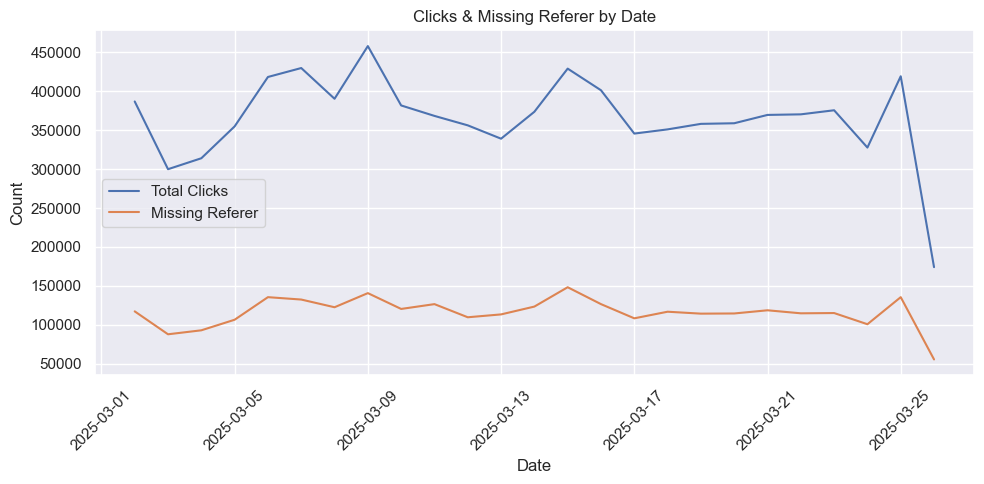

In [210]:
fig, ax = plt.subplots(figsize=(10, 5))

# Linie 1: Total Clicks
sns.lineplot(x='click_date', y='total_clicks', data=clicks_date_df.reset_index(), ax=ax, label='Total Clicks')

# Linie 2: Fehlende Referer
missing_by_date = data_df.groupby('click_date')['REFERER_MISSING'].sum().reset_index()
sns.lineplot(x='click_date', y='REFERER_MISSING', data=missing_by_date, ax=ax, label='Missing Referer')

# Achsentitel usw.
ax.set(title="Clicks & Missing Referer by Date", xlabel="Date", ylabel="Count")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

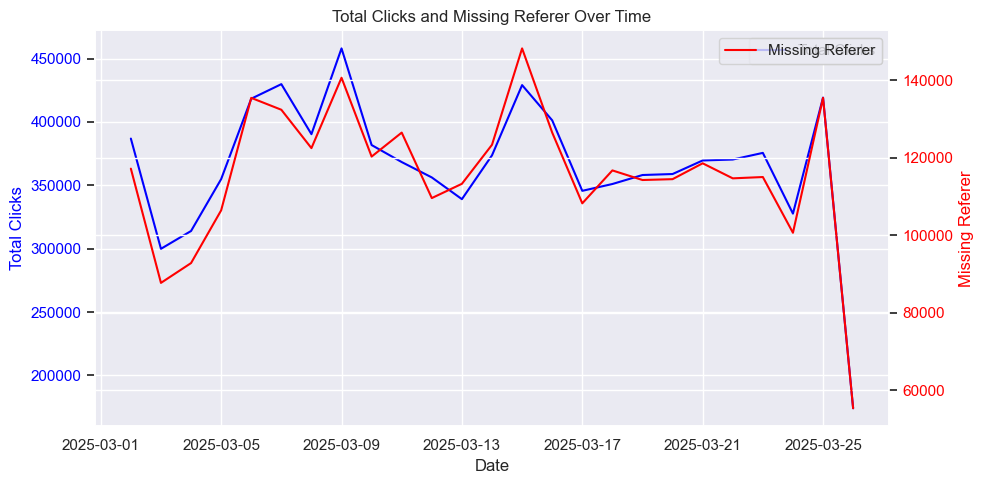

In [211]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Achse 1: Total Clicks
sns.lineplot(x='click_date', y='total_clicks', data=clicks_date_df.reset_index(), ax=ax1, label='Total Clicks', color='blue')
ax1.set_ylabel('Total Clicks', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Zweite Y-Achse
ax2 = ax1.twinx()
missing_by_date = data_df.groupby('click_date')['REFERER_MISSING'].sum().reset_index()
sns.lineplot(x='click_date', y='REFERER_MISSING', data=missing_by_date, ax=ax2, label='Missing Referer', color='red')
ax2.set_ylabel('Missing Referer', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title("Total Clicks and Missing Referer Over Time")
ax1.set_xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()


In [212]:
data_df.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,REFERER_MISSING
0,623979187,5418289,rakuten-hm-pl,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Other,True
1,623979186,5417799,amazon-uk,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylist,False
2,623979185,5416047,amazon-de,290448983.0,LightUser,185.131.74.168,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/32YYmiJV...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False
3,623979184,5418504,amazon-uk,290447611.0,LightUser,188.30.133.168,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/L4lQhl7B...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False
4,623979183,5418042,rakuten-hm-de,290449008.0,LightUser,178.115.44.179,at,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,https://app.stylink.com/ref_ios/redir/DQq9AS9l...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False


In [213]:

# Gruppiere nach Datum
daily_stats = data_df.groupby('click_date').agg(
    total_clicks=('ID', 'count'),
    #wie viel ist die Anzahl der true-Werte
    missing_referer_clicks=('REFERER_MISSING', 'sum')
).reset_index()

# Verhältnis berechnen
daily_stats['missing_referer_ratio'] = daily_stats['missing_referer_clicks'] / daily_stats['total_clicks']


In [214]:
daily_stats.head()

,click_date,total_clicks,missing_referer_clicks,missing_referer_ratio
0,2025-03-02,386912,117197,0.302904
1,2025-03-03,299892,87745,0.292589
2,2025-03-04,313953,92851,0.295748
3,2025-03-05,354900,106445,0.299930
4,2025-03-06,418385,135445,0.323733


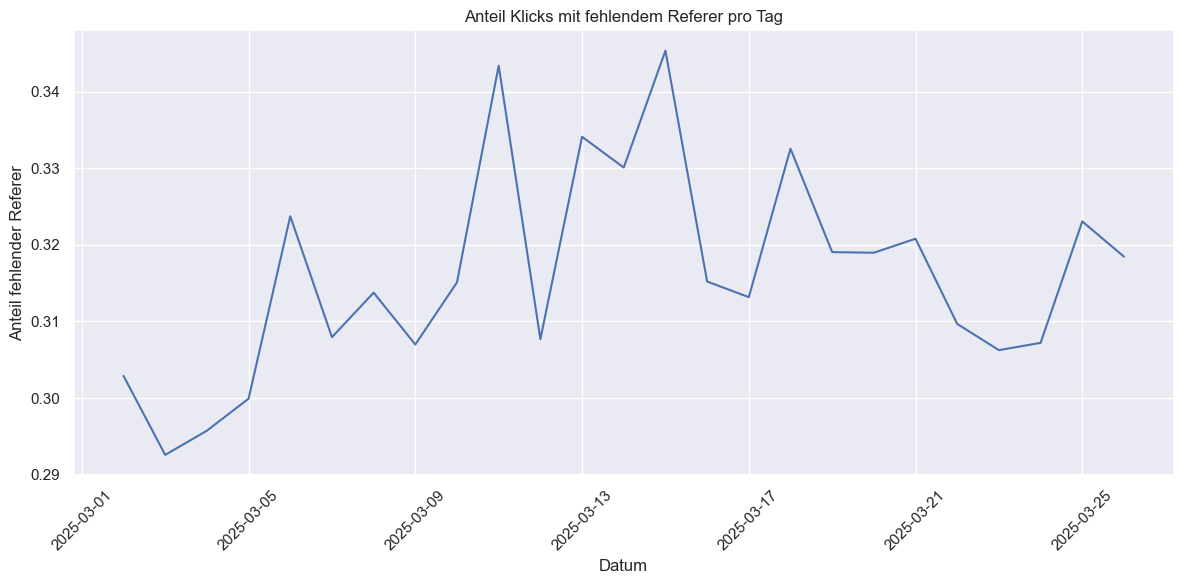

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x='click_date', y='missing_referer_ratio', data=daily_stats)
plt.title('Anteil Klicks mit fehlendem Referer pro Tag')
plt.xlabel('Datum')
plt.ylabel('Anteil fehlender Referer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Pattern Recognition

Referer-Hosts, die sich aus dem USER_AGENT ableiten lassen.

Reminder:

In [216]:
data_df[data_df['REFERER'].isna()]['USER_AGENT'].value_counts().head(20)

Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/27.0 Chrome/125.0.0.0 Mobile Safari/537.36                                                                                                1081522
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Mobile Safari/537.36                                                                                                                     578218
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Mobile Safari/537.36                                                                                                                     504910
Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Mobile/15E148 Safari/604.1                                                                                           100942
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36

In [217]:
def infer_referer_host(user_agent):
    ua = str(user_agent).lower()

    # Soziale Netzwerke & Messenger
    if 'instagram' in ua:
        return 'instagram.com'
    elif 'tiktok' in ua:
        return 'tiktok.com'
    elif 'facebook' in ua:
        return 'facebook.com'
    elif 'whatsapp' in ua:
        return 'whatsapp.com'
    elif 'pinterest' in ua:
        return 'pinterest.com'
    elif 'telegram' in ua:
        return 'telegram.org'
    elif 'linkedin' in ua:
        return 'linkedin.com'
    elif 'snapchat' in ua:
        return 'snapchat.com'
    elif 'telegram' in ua:
        return 'telegram.com'
    elif 'twitter' in ua or 'x-twitter' in ua:
        return 'twitter.com'
    elif 'messenger' in ua:
        return 'facebook.com'

    # Suchmaschinen / Referrer-Schutz
    elif 'google' in ua and 'app' in ua:
        return 'google-app'
    elif 'googlebot' in ua:
        return 'bot'
    elif 'bingbot' in ua:
        return 'bot'
    elif 'yahoo' in ua and 'bot' in ua:
        return 'bot'

    # Browser ohne Referrer oder aus Datenschutzgründen entfernt
    elif 'duckduckgo' in ua:
        return 'duckduckgo.com'
    elif 'brave' in ua:
        return 'brave-browser'
    elif 'SamsungBrowser' in ua:
        return 'samsung-browser'
    elif 'Firefox' in ua:
        return 'firefox'

    # Mobile In-App Browser
    elif 'inapp' in ua or 'webview' in ua or 'wv' in ua:
        return 'in-app-browser'
    elif 'okhttp' in ua:
        return 'mobile-app'

    # Mail-Clients
    elif 'email' in ua or 'mail' in ua or 'outlook' in ua or 'thunderbird' in ua:
        return 'email-client'

    # Crawler, Bots & Tools
    elif 'bot' in ua or 'crawler' in ua or 'spider' in ua or 'preview' in ua or 'python-requests' in ua:
        return 'bot'

    # Messenger & Copy-Paste-Dienste
    elif 'sms' in ua or 'mms' in ua:
        return 'sms'
    elif 'copy' in ua or 'clipboard' in ua:
        return 'copy-link'

    else:
        return None

In [218]:

data_df['INFERRED_REFERER_HOST'] = data_df['USER_AGENT'].apply(infer_referer_host)

In [219]:
data_df.query('INFERRED_REFERER_HOST.notnull()').head(10)

,ID,PRODUCT_LINK_ID,SOURCE_ID,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,REFERER_MISSING,INFERRED_REFERER_HOST
1,623979186,5417799,amazon-uk,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylist,False,in-app-browser
25,623979159,5380917,rakuten-hm-de,NaN,NaN,46.234.240.174,it,True,Mozilla/5.0 (Linux; Android 13; M2103K19G Buil...,http://m.facebook.com/,facebook,False,2025-03-26 12:22:59,2025-03-26,26,2,12,False,Wednesday,Social Media,False,in-app-browser
30,623979156,5418289,rakuten-hm-pl,NaN,NaN,77.222.245.191,pl,False,Mozilla/5.0 (Linux; Android 13; CPH2343 Build/...,http://m.facebook.com/,facebook,False,2025-03-26 12:22:58,2025-03-26,26,2,12,False,Wednesday,Social Media,False,in-app-browser
153,623979034,5407721,rakuten-hm-de,NaN,NaN,176.1.203.105,de,False,Mozilla/5.0 (Linux; Android 14; SM-S921B Build...,NaN,NaN,False,2025-03-26 12:22:43,2025-03-26,26,2,12,False,Wednesday,Other,True,google-app
254,623978944,5014622,cj-allegro-pl,NaN,NaN,31.13.127.4,ie,True,Mozilla/5.0 (Linux; Android 12; SM-A135F Build...,NaN,NaN,False,2025-03-26 12:22:29,2025-03-26,26,2,12,False,Wednesday,Other,True,in-app-browser
500,623978688,5418379,rakuten-next-ch,NaN,NaN,66.249.81.133,us,True,Mozilla/5.0 (Linux; Android 7.0; SM-G930V Buil...,NaN,NaN,False,2025-03-26 12:21:57,2025-03-26,26,2,12,False,Wednesday,Other,True,google-app
697,623978491,5411787,rakuten-hm-de,NaN,NaN,77.202.177.59,fr,True,Mozilla/5.0 (Linux; Android 14; SM-S901B Build...,https://linktr.ee/,linktr,False,2025-03-26 12:21:26,2025-03-26,26,2,12,False,Wednesday,Other,False,google-app
800,623978387,5416401,cj-nobodyschild-uk,NaN,NaN,80.4.66.220,gb,False,Mozilla/5.0 (Linux; Android 12; M2007J20CG Bui...,http://m.facebook.com/,facebook,False,2025-03-26 12:21:13,2025-03-26,26,2,12,False,Wednesday,Social Media,False,in-app-browser
846,623978342,5330058,tradedoubler-ikea-de,NaN,NaN,77.21.220.55,de,False,Mozilla/5.0 (Linux; Android 14; SM-S918B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:21:09,2025-03-26,26,2,12,False,Wednesday,Stylist,False,google-app
941,623978246,5290802,rakuten-hm-de,NaN,NaN,77.202.177.59,fr,True,Mozilla/5.0 (Linux; Android 14; SM-S901B Build...,https://linktr.ee/,linktr,False,2025-03-26 12:20:55,2025-03-26,26,2,12,False,Wednesday,Other,False,google-app


In [220]:
data_df.query('INFERRED_REFERER_HOST.notnull()').INFERRED_REFERER_HOST.unique()

array(['in-app-browser', 'google-app', 'instagram.com', 'facebook.com',
       'pinterest.com', 'twitter.com', 'email-client', 'duckduckgo.com',
       'bot', 'linkedin.com', 'sms', 'telegram.org'], dtype=object)

### Fehlende Referer rekonstruieren

Fehlenden Werte gezielt füllen:

In [221]:
data_df['REFERER_HOST_FILL'] = data_df['REFERER_HOST'].fillna(data_df['INFERRED_REFERER_HOST'])


Optional: Nur füllen, wenn REFERER und REFERER_HOST leer sind.

In [222]:
data_df[['REFERER_HOST', 'INFERRED_REFERER_HOST', 'REFERER_HOST_FILL']].query('INFERRED_REFERER_HOST.notnull()')

,REFERER_HOST,INFERRED_REFERER_HOST,REFERER_HOST_FILL
1,stylist,in-app-browser,stylist
25,facebook,in-app-browser,facebook
30,facebook,in-app-browser,facebook
153,NaN,google-app,google-app
254,NaN,in-app-browser,in-app-browser
...,...,...,...
9151936,NaN,in-app-browser,in-app-browser
9152092,NaN,google-app,google-app
9152229,facebook,in-app-browser,facebook
9152261,facebook,in-app-browser,facebook


In [223]:
# Zeilen, wo REFERER_HOST_FILL immer noch NaN ist
remaining_missing = data_df['REFERER_HOST_FILL'].isna()
print(f"Übrig gebliebene fehlende REFERER_HOSTs: {remaining_missing.sum()}")

Übrig gebliebene fehlende REFERER_HOSTs: 2850949


Die verbleibenden Fälle isolieren:

In [224]:
remaining_df = data_df[remaining_missing]

Neue Fälle finden will:

In [225]:
# User Agents ohne Zuordnung analysieren
unmapped_uas = data_df[data_df['REFERER_HOST_FILL'].isna()]['USER_AGENT'].value_counts().head(10)
print(unmapped_uas)

Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/27.0 Chrome/125.0.0.0 Mobile Safari/537.36            1081522
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Mobile Safari/537.36                                 578218
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Mobile Safari/537.36                                 504910
Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Mobile/15E148 Safari/604.1       100942
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36 Edg/87.0.664.60               71082
Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3.1 Mobile/15E148 Safari/604.1      55222
Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) 

#### Weitere Zusammenhänge finden
Suche nach auffällige Muster, die sich bei diesen verbliebenden NaN-Fällen zeigen:

In [226]:
for col in ['SOURCE_ID', 'ACTOR_TYPE', 'IP_COUNTRY', 'FOREIGN_COUNTRY']:
    print(f"\nTop Gruppen mit fehlendem REFERER_HOST_FILL nach {col}:")
    print(remaining_df[col].value_counts().head())


Top Gruppen mit fehlendem REFERER_HOST_FILL nach SOURCE_ID:
amazon-de           492526
rakuten-hm-de       484510
rakuten-hmvip-pl    100749
rakuten-hmvip-de     98043
private-otto         96844
Name: SOURCE_ID, dtype: int64

Top Gruppen mit fehlendem REFERER_HOST_FILL nach ACTOR_TYPE:
LightUser    2356107
User              12
Name: ACTOR_TYPE, dtype: int64

Top Gruppen mit fehlendem REFERER_HOST_FILL nach IP_COUNTRY:
de    1402474
pl     411672
gb     303998
nl     146732
at     101691
Name: IP_COUNTRY, dtype: int64

Top Gruppen mit fehlendem REFERER_HOST_FILL nach FOREIGN_COUNTRY:
False    2490763
True      359840
Name: FOREIGN_COUNTRY, dtype: int64


## Fraud Detection 

Fraud detection in click data can be done by identifying anomalous patterns, such as excessive clicks from the same IP, rapid clicks in a short period, or unusual user_agent behavior.

### Detecting Unusual Traffic Sources
If we suspect bot traffic, look for unusual or unknown referrers.

We flag referrers that have an unusually low number of clicks, as these might be bots or anomalies. Flags referer_host values with fewer than 5 clicks (adjustable).These might be bots or fraudulent sources.

In [227]:
def detect_unusual_referers(df, threshold=5):
    referer_counts = df['REFERER_HOST_FILL'].value_counts()
    unusual_referers = referer_counts[referer_counts < threshold].index
    df['fraud_suspicious_referer'] = df['REFERER_HOST_FILL'].isin(unusual_referers)
    return df

df = detect_unusual_referers(data_df)
suspicious_referer_df = df[df['fraud_suspicious_referer']]
print(suspicious_referer_df.head(10))
print(suspicious_referer_df.REFERER_HOST_FILL.nunique())
print(suspicious_referer_df.REFERER_HOST_FILL.unique())

               ID  PRODUCT_LINK_ID           SOURCE_ID  ACTOR_ID ACTOR_TYPE              IP IP_COUNTRY FOREIGN_COUNTRY                                         USER_AGENT                                            REFERER        REFERER_HOST  PROCESSED          CREATED_AT  click_date  click_day  click_day_of_week  click_hour  weekend    weekday referer_category  REFERER_MISSING INFERRED_REFERER_HOST   REFERER_HOST_FILL  fraud_suspicious_referer
81582   623897610          3467636        private-otto       NaN        NaN     212.3.80.50         de           False  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  https://25399044.hubspotpreview-eu1.com/_hcms/...  hubspotpreview-eu1       True 2025-03-26 08:55:17  2025-03-26         26                  2           8    False  Wednesday            Other            False                  None  hubspotpreview-eu1                      True
111026  623868162          4360154      impact-temu-nl       NaN        NaN  178.85.243.146         nl  

In [228]:
wth_actor_df = data_df.query('ACTOR_ID.isnull()')
wth_actor_df.head(10)

,ID,PRODUCT_LINK_ID,SOURCE_ID,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,REFERER_MISSING,INFERRED_REFERER_HOST,REFERER_HOST_FILL,fraud_suspicious_referer
1,623979186,5417799,amazon-uk,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylist,False,in-app-browser,stylist,False
10,623979179,5414877,amazon-pl,NaN,NaN,37.31.18.135,pl,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/DQRnmF9l...,stylink,False,2025-03-26 12:23:01,2025-03-26,26,2,12,False,Wednesday,Stylink,False,None,stylink,False
12,623979180,5252984,rakuten-uk-urban-outfitters-uk,NaN,NaN,112.197.233.43,vn,True,Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build...,NaN,NaN,False,2025-03-26 12:23:01,2025-03-26,26,2,12,False,Wednesday,Other,True,None,None,False
20,623979173,4348479,awin-stradivarius-de,NaN,NaN,89.247.32.44,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 16_4_1 like...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:00,2025-03-26,26,2,12,False,Wednesday,Stylist,False,None,stylist,False
25,623979159,5380917,rakuten-hm-de,NaN,NaN,46.234.240.174,it,True,Mozilla/5.0 (Linux; Android 13; M2103K19G Buil...,http://m.facebook.com/,facebook,False,2025-03-26 12:22:59,2025-03-26,26,2,12,False,Wednesday,Social Media,False,in-app-browser,facebook,False
26,623979160,2762700,rakuten-hm-de,NaN,NaN,81.220.93.0,fr,True,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,NaN,NaN,False,2025-03-26 12:22:59,2025-03-26,26,2,12,False,Wednesday,Other,True,None,None,False
30,623979156,5418289,rakuten-hm-pl,NaN,NaN,77.222.245.191,pl,False,Mozilla/5.0 (Linux; Android 13; CPH2343 Build/...,http://m.facebook.com/,facebook,False,2025-03-26 12:22:58,2025-03-26,26,2,12,False,Wednesday,Social Media,False,in-app-browser,facebook,False
34,623979154,5252990,rakuten-uk-urban-outfitters-uk,NaN,NaN,88.147.189.226,ru,True,Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build...,NaN,NaN,False,2025-03-26 12:22:58,2025-03-26,26,2,12,False,Wednesday,Other,True,None,None,False
42,623979148,4955613,stylink-stylink-uk,NaN,NaN,92.40.193.141,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_2 like M...,https://app.stylink.com/ref_ios/redir/3Z7XoFJN...,stylink,False,2025-03-26 12:22:57,2025-03-26,26,2,12,False,Wednesday,Stylink,False,None,stylink,False
43,623979135,5415888,rakuten-hm-de,NaN,NaN,154.194.23.126,us,True,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,NaN,False,2025-03-26 12:22:56,2025-03-26,26,2,12,False,Wednesday,Other,True,None,None,False


In [229]:
data_df.ACTOR_TYPE.unique()

array(['LightUser', nan, 'User'], dtype=object)

In [230]:
data_df.query("ACTOR_TYPE=='User'")

,ID,PRODUCT_LINK_ID,SOURCE_ID,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,REFERER_MISSING,INFERRED_REFERER_HOST,REFERER_HOST_FILL,fraud_suspicious_referer
6348,623972841,5165548,digidip-tui-uk,65932.0,User,86.175.122.20,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,https://app.stylink.com/ref_ios/redir/YAegTyLA...,stylink,True,2025-03-26 12:09:21,2025-03-26,26,2,12,False,Wednesday,Stylink,False,None,stylink,False
6436,623972754,5165548,digidip-tui-uk,65932.0,User,86.175.122.20,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,https://app.stylink.com/ref_ios/redir/YAegTyLA...,stylink,True,2025-03-26 12:09:09,2025-03-26,26,2,12,False,Wednesday,Stylink,False,None,stylink,False
7144,623972041,5418463,rakuten-hmvip-pl,167354.0,User,94.254.145.87,pl,False,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,https://app.stylink.com/ref_ios/redir/5YjpyFwP...,stylink,True,2025-03-26 12:07:37,2025-03-26,26,2,12,False,Wednesday,Stylink,False,None,stylink,False
11119,623968068,5418235,rakuten-hm-de,161749.0,User,80.187.67.82,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/q2R6YS3M...,stylink,True,2025-03-26 11:59:41,2025-03-26,26,2,11,False,Wednesday,Stylink,False,None,stylink,False
11355,623967834,5418078,rakuten-hm-de,161749.0,User,80.187.67.82,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/QPdXbHGD...,stylink,True,2025-03-26 11:59:14,2025-03-26,26,2,11,False,Wednesday,Stylink,False,None,stylink,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115371,614863816,5330315,private-otto,255418.0,User,94.134.111.164,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,https://app.stylink.com/ref_ios/redir/OxvdBtzo...,stylink,True,2025-03-02 07:38:27,2025-03-02,2,6,7,False,Sunday,Stylink,False,None,stylink,False
9117104,614862079,5330906,rakuten-hm-uk,194052.0,User,172.226.116.51,es,True,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,https://app.stylink.com/ref_ios/redir/DQJvJs9x...,stylink,True,2025-03-02 07:30:36,2025-03-02,2,6,7,False,Sunday,Stylink,False,None,stylink,False
9134383,614844804,5330599,amazon-de,271467.0,User,88.130.48.205,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,https://app.stylink.com/ref_ios/redir/ZN9PhpB7...,stylink,True,2025-03-02 04:57:01,2025-03-02,2,6,4,False,Sunday,Stylink,False,None,stylink,False
9139761,614839426,4101871,private-home24-de,190394.0,User,91.17.214.36,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,https://app.stylink.com/ref_ios/redir/X54bvI5g...,stylink,True,2025-03-02 03:05:12,2025-03-02,2,6,3,False,Sunday,Stylink,False,None,stylink,False


In [231]:
user_agent_all_df = data_df.groupby("USER_AGENT")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
user_agent_all_df.columns = ["USER_AGENT", "total_clicks"]
user_agent_all_df.head(10)

,USER_AGENT,total_clicks
0,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,2415531
1,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,1307662
2,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,1116408
3,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,620069
4,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,543816
5,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1_1 like...,343328
6,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,337316
7,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,183911
8,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,163763
9,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,123968


# Missing Referer Host

In [232]:
pr_lnk_df = remaining_df.groupby("SOURCE_ID")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
pr_lnk_df.columns = ["SOURCE_ID", "total_clicks"]
pr_lnk_df.head(10)

,SOURCE_ID,total_clicks
0,amazon-de,492526
1,rakuten-hm-de,484510
2,rakuten-hmvip-pl,100749
3,rakuten-hmvip-de,98043
4,private-otto,96844
5,rakuten-nl-hm-nl,91553
6,rakuten-hm-pl,88726
7,amazon-uk,82093
8,rakuten-hm-uk,76342
9,impact-asos-de,61805


In [233]:
ip_country_df = remaining_df.groupby("IP_COUNTRY")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ip_country_df.columns = ["IP_COUNTRY", "total_clicks"]
ip_country_df.head(10)

,IP_COUNTRY,total_clicks
0,de,1402474
1,pl,411672
2,gb,303998
3,nl,146732
4,at,101691
5,us,87462
6,ie,78061
7,fr,64914
8,ch,39013
9,ru,24695


## Analyzing Direct Traffic (Clicks Without a Referrer)
If a specific source_id has lots of missing referrers, that source might use direct links.

In [234]:
# Check sources with missing referers
direct_traffic_sources = data_df[data_df['REFERER_HOST'].isna()]['SOURCE_ID'].value_counts()
print(direct_traffic_sources.head(10))

amazon-de           495473
rakuten-hm-de       489690
rakuten-hmvip-pl    101500
private-otto         98520
rakuten-hmvip-de     98335
rakuten-nl-hm-nl     92562
rakuten-hm-pl        89275
amazon-uk            82871
rakuten-hm-uk        78114
impact-asos-de       63951
Name: SOURCE_ID, dtype: int64


In [235]:
known_referers_df = pd.DataFrame(data_df.dropna(subset=['REFERER_HOST']).groupby(['IP', 'USER_AGENT', 'SOURCE_ID'])['REFERER_HOST'].first())

In [236]:
known_referers_df.tail(10)

REFERER_HOST
IP            USER_AGENT                                         SOURCE_ID                        
99.98.241.57  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)... awin-jd-sports-de       instagram
99.98.246.68  Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like ... impact-uk-asos-uk         stylink
99.98.250.162 Mozilla/5.0 (iPhone; CPU iPhone OS 16_0_1 like ... awin-parfumdreams-de      stylink
99.98.3.178   Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like ... awin-sephora-de           stylink
                                                                 stylink-douglas-de        stylink
99.98.74.22   Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like ... rakuten-hm-uk           instagram
99.98.81.123  Mozilla/5.0 (iPhone; CPU iPhone OS 18_3 like Ma... impact-johnlewis-uk       stylink
                                                                 rakuten-hm-uk             stylink
99.99.12.75   Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like ... awin-boots-uk             stylink
99.99.208.17  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)... cj-tuclothing-uk          stylink

In [237]:
known_referers_df.query("REFERER_HOST == 'facebook.com'").head(10)

,,,REFERER_HOST
IP,USER_AGENT,SOURCE_ID,


# Inferring `referer_host` Using Click Patterns

If multiple users with the same IP, user-agent, and source_id have a known referer_host, we can then apply that referer to missing ones?

In [238]:
def infer_referer_from_patterns(df):
    # Find known referer_host per (ip, user_agent, source_id)
    # The function filters out rows where REFERER_HOST is missing.
    # Then, it groups the data by IP, USER_AGENT, and SOURCE_ID.
    # The .first() function picks the first non-null referer for each combination.
    known_referers = df.dropna(subset=['REFERER_HOST_FILL']).groupby(['IP','USER_AGENT', 'SOURCE_ID'])['REFERER_HOST_FILL'].first()

    # Fill missing referer_host based on known patterns
    df['REFERER_HOST_NEW'] = df.apply(
        lambda row: known_referers.get((row['IP'], row['USER_AGENT'], row['SOURCE_ID']), row['REFERER_HOST']),
        axis=1
    )

    return df

df_patterns = infer_referer_from_patterns(data_df)


It goes row by row (apply(axis=1)) and Looks up (IP, USER_AGENT, SOURCE_ID) in known_referers. If a match exists, it fills in REFERER_HOST. If no match is found, it keeps the existing value.

In [239]:
df_patterns.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,REFERER_MISSING,INFERRED_REFERER_HOST,REFERER_HOST_FILL,fraud_suspicious_referer,REFERER_HOST_NEW
0,623979187,5418289,rakuten-hm-pl,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Other,True,None,None,False,NaN
1,623979186,5417799,amazon-uk,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylist,False,in-app-browser,stylist,False,stylist
2,623979185,5416047,amazon-de,290448983.0,LightUser,185.131.74.168,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/32YYmiJV...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False,None,stylink,False,stylink
3,623979184,5418504,amazon-uk,290447611.0,LightUser,188.30.133.168,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/L4lQhl7B...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False,None,stylink,False,stylink
4,623979183,5418042,rakuten-hm-de,290449008.0,LightUser,178.115.44.179,at,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,https://app.stylink.com/ref_ios/redir/DQq9AS9l...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylink,False,None,stylink,False,stylink


In [240]:
ref_host_df.head(10)

,REFERER_HOST,total_clicks
0,stylink,5794888
1,instagram,155372
2,youtube,95520
3,facebook,78139
4,stylist,36659
5,pinterest,18572
6,linktr,11243
7,mittlivpalandet,11227
8,minimalissmo,6649
9,diski,5637


In [241]:
ref_host_check_df = df_patterns.groupby("REFERER_HOST_NEW")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ref_host_check_df.columns = ["REFERER_HOST_NEW", "total_clicks"]
ref_host_check_df.head(10)

,REFERER_HOST_NEW,total_clicks
0,stylink,5883264
1,instagram,175290
2,youtube,96965
3,facebook,78235
4,stylist,38045
5,in-app-browser,24082
6,pinterest,19418
7,google-app,17818
8,linktr,11336
9,mittlivpalandet,11296


Flags `referer_host` values with fewer than 5 clicks (adjustable) might be bots or fraudulent sources.

In [242]:
def flag_unusual_referers(df, min_threshold=5):
    referer_counts = df['REFERER_HOST_FILL'].value_counts()
    unusual_referers = referer_counts[referer_counts < min_threshold].index

    df['fraud_unusual_referer'] = df['REFERER_HOST_FILL'].isin(unusual_referers)
    return df

df_unusual_referers = flag_unusual_referers(data_df)
print(df_unusual_referers[df_unusual_referers['fraud_unusual_referer']])


                ID  PRODUCT_LINK_ID                      SOURCE_ID     ACTOR_ID ACTOR_TYPE               IP IP_COUNTRY FOREIGN_COUNTRY                                         USER_AGENT                                            REFERER               REFERER_HOST  PROCESSED          CREATED_AT  click_date  click_day  click_day_of_week  click_hour  weekend    weekday referer_category  REFERER_MISSING INFERRED_REFERER_HOST          REFERER_HOST_FILL  fraud_suspicious_referer           REFERER_HOST_NEW  fraud_unusual_referer
81582    623897610          3467636                   private-otto          NaN        NaN      212.3.80.50         de           False  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  https://25399044.hubspotpreview-eu1.com/_hcms/...         hubspotpreview-eu1       True 2025-03-26 08:55:17  2025-03-26         26                  2           8    False  Wednesday            Other            False                  None         hubspotpreview-eu1                     